## Machine Learning Second Home Assignment
Group number: 14

#### Import libraries and dataset

In [27]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [28]:
# Import dataset
df = pd.read_csv("Postures.csv", na_values = "?")

#### Functions

In [42]:
def calculate_mcc(y_test, preds, imputer, model, results):
    mcc = matthews_corrcoef(y_test, preds)
    results.append({
        'Scaler': str(scaler),
        'Imputer': str(imputer),
        'Model': str(model),
        'MCC': mcc
    })

In [30]:
def runner(scaler, imputer, modeler, X_train, y_train, X_test):
    scaler.fit(X_train)
    Xt_train = scaler.transform(X_train)
    Xt_test = scaler.transform(X_test)
    imputer.fit(Xt_train)
    Xt_train = imputer.transform(Xt_train)
    Xt_test = imputer.transform(Xt_test)
    modeler.fit(Xt_train, y_train)
    return modeler.predict(Xt_test)

In [31]:
def runner_imp(imputer, modeler, X_train, y_train, X_test):
    imputer.fit(X_train)
    Xt_train = imputer.transform(X_train)
    Xt_test = imputer.transform(X_test)
    modeler.fit(Xt_train, y_train)
    return modeler.predict(Xt_test)

### Step 0. Pre-processing the data

#### 0.1 Examining dataset

In [32]:
# Dataset shape
df.shape

(78096, 38)

#### 0.2 Eliminate first row, transform "User" variable into cathegorical and check if the dependent variable "Class" contains no missing values

In [34]:
# Eliminate the first row of the data set as there are only Zeros
df = df.tail(-1)

In [35]:
#  Transform "User" variable into cathegorical
df['User'] = pd.Categorical(df.User)

In [36]:
# Check whether the dependent variable "Class" contains missing values
df[df['Class'].isna()]

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11


### Step 1. Split the data set into a training and testing set

In [37]:
# Splitting the dataset into train and test sets
X = df.drop(columns=['Class']) 
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4)

In [38]:
# Print the number of instances in each class
vals, counts= np.unique(y_train, return_counts=True)
for v, c in zip(vals, counts):
    print("Nr. of instances in class ", v, "--->", c)

Nr. of instances in class  1 ---> 12202
Nr. of instances in class  2 ---> 11225
Nr. of instances in class  3 ---> 12159
Nr. of instances in class  4 ---> 11118
Nr. of instances in class  5 ---> 11867


### Step 2. Scale the data

#### Finding the best scaler

In [120]:
scalers = [StandardScaler(), PowerTransformer(), MinMaxScaler()]
imputer = SimpleImputer()
models = [KNeighborsClassifier(), LogisticRegression(max_iter=100000), DecisionTreeClassifier(), GaussianNB()]
results = []

for scaler in scalers:
    for model in models:
        preds = runner(scaler, imputer, model, X_train, y_train, X_test)
        calculate_mcc(y_test, preds, imputer, model, results)
        
mcc_table_scalers = pd.DataFrame(results)
mcc_table_scalers = mcc_table_scalers.sort_values(by='MCC', ascending=False)
mcc_table_scalers[:5]

,Scaler,Imputer,Model,MCC
10,MinMaxScaler(),SimpleImputer(),DecisionTreeClassifier(),0.950608
6,PowerTransformer(),SimpleImputer(),DecisionTreeClassifier(),0.949969
2,StandardScaler(),SimpleImputer(),DecisionTreeClassifier(),0.948813
8,MinMaxScaler(),SimpleImputer(),KNeighborsClassifier(),0.933774
0,StandardScaler(),SimpleImputer(),KNeighborsClassifier(),0.918470


#### Apply the selected scaler to data

In [45]:
columns = list(X_train.columns.values)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns = columns)

### Step 3. Dealing with missing values

#### 3.1 Exploring Impact of Column Elimination on Model Performance

In [121]:
models = [KNeighborsClassifier(), LogisticRegression(max_iter=100000), DecisionTreeClassifier(), GaussianNB()]
imputer = SimpleImputer()
thresholds = [0.5, 0.6, 0.7]
results = []

for threshold in thresholds:
    missing_train = X_train_scaled.isna().mean()
    missing_test = X_test_scaled.isna().mean()

    elim_var_train = missing_train[missing_train > threshold]
    elim_var_names = list(elim_var_train.index.values)

    X_train_reduced = X_train_scaled.drop(columns=elim_var_names)
    X_test_reduced = X_test_scaled.drop(columns=elim_var_names)
    

    for model in models:
        preds_reduced = runner_imp(imputer, model, X_train_reduced, y_train, X_test_reduced)
        mcc = matthews_corrcoef(y_test, preds_reduced)
        results.append({
            'Threshold': threshold,
            'Model': str(model),
            'MCC': mcc
        })
        
mcc_table = pd.DataFrame(results)
mcc_table = mcc_table.sort_values(by='MCC', ascending=False)
mcc_table[:5]

,Threshold,Model,MCC
6,0.6,DecisionTreeClassifier(),0.950548
10,0.7,DecisionTreeClassifier(),0.947727
8,0.7,KNeighborsClassifier(),0.929408
4,0.6,KNeighborsClassifier(),0.920298
2,0.5,DecisionTreeClassifier(),0.911857


#### Dropping columns with more than 70% of missing values

In [108]:
threshold = 0.7 #Selected threshold
missing_percentage = X_train_scaled.isna().mean()
columns_to_eliminate = missing_percentage[missing_percentage > threshold].index
elim_var_names = list(columns_to_eliminate.values)
X_train_reduced = X_train_scaled.drop(columns=columns_to_eliminate, axis = 1)
X_test_reduced = X_test_scaled.drop(columns=columns_to_eliminate, axis = 1)

#### 3.2 Imputation of missing values

#### Finding the best imputer

To identify the optimal imputer, we perform the selection process on a smaller sample. This approach is chosen due to the computational demands associated with evaluating imputers on the entire dataset. The sample serves as a representative subset for efficient imputer assessment.

In [64]:
stratified_subset, _ = train_test_split(df, test_size=0.9, stratify=df['Class'], random_state=42)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(stratified_subset.drop('Class', axis=1), stratified_subset['Class'], test_size=0.25, random_state=42)

In [65]:
columns = list(X_train_small.columns.values)
selected_scaler = MinMaxScaler()
selected_scaler.fit(X_train_small)
X_train_scaled_small = pd.DataFrame(selected_scaler.transform(X_train_small), columns = columns)
X_test_scaled_small  = pd.DataFrame(selected_scaler.transform(X_test_small), columns = columns)

In [66]:
threshold = 0.7 # Your selected threshold
missing_percentage = X_train_scaled_small.isna().mean()
columns_to_eliminate = missing_percentage[missing_percentage > threshold].index
X_train_reduced_small = X_train_scaled_small.drop(columns=columns_to_eliminate, axis = 1)
X_test_reduced_small = X_test_scaled_small.drop(columns=columns_to_eliminate, axis = 1)

In [122]:
models = [KNeighborsClassifier(), LogisticRegression(max_iter=100000), DecisionTreeClassifier(), GaussianNB()]
imputers = [SimpleImputer(missing_values=np.nan, strategy='mean'),
            SimpleImputer(missing_values=np.nan, strategy='median'), KNNImputer(n_neighbors = 1), KNNImputer(n_neighbors = 5), KNNImputer(n_neighbors = 20)]
results = []

# Nested loops
for imputer in imputers:
    for model in models:
        preds_imp = runner_imp(imputer, model, X_train_reduced_small, y_train_small, X_test_reduced_small)  
        calculate_mcc(y_test_small, preds_imp, imputer, model, results)
        
mcc_table_imp = pd.DataFrame(results)
mcc_table_imp = mcc_table_imp.sort_values(by='MCC', ascending=False)
mcc_table_imp[:5]

,Scaler,Imputer,Model,MCC
2,MinMaxScaler(),SimpleImputer(),DecisionTreeClassifier(),0.824527
6,MinMaxScaler(),SimpleImputer(strategy='median'),DecisionTreeClassifier(),0.818260
0,MinMaxScaler(),SimpleImputer(),KNeighborsClassifier(),0.767269
16,MinMaxScaler(),KNNImputer(n_neighbors=20),KNeighborsClassifier(),0.766346
18,MinMaxScaler(),KNNImputer(n_neighbors=20),DecisionTreeClassifier(),0.763082


#### Using the selected imputer on the entire dataset

In [91]:
# Perform a multivariate imputation with KNN
imputer = SimpleImputer()
imputer.fit(X_train_reduced)
X_train_processed = imputer.transform(X_train_reduced)
X_test_processed  = imputer.transform(X_test_reduced)

### Step 4. Fitting the models

#### 4.1 Linear models

##### 4.1.1 Logistic Regression

In [92]:
# Create an empty list to store the results
res_lr = []

# Define a list of hyperparameters to test
c_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Loop through the hyperparameter combinations and calculate Accuracy and MCC for each model
for C in c_range:
    model_name_lr = f'Logistic Regression (L2) (C={C})'
    if not any(result_lr['Model Name'] == model_name_lr for result_lr in res_lr):
        model_lr = LogisticRegression(max_iter = 100000, C = C, random_state = 4)
        model_lr = model_lr.fit(X_train_processed, y_train)
        preds_lr = model_lr.predict(X_test_processed)
        res_lr.append({'Model Name': model_name_lr, 'Accuracy': accuracy_score(y_test, preds_lr), 'MCC': matthews_corrcoef(y_test, preds_lr)})

##### 4.1.2 Linear Discriminant Analysis

In [93]:
# Create an empty list to store the results
res_lda = []

# Define a list of hyperparameters to test
solver = ["svd", "lsqr", "eigen"]

# Loop through the hyperparameter combinations and calculate Accuracy and MCC for each model
for solver in solver:
    model_name_lda = f'Linear Discriminant Analyss (solver={solver})'
    if not any(result_lda['Model Name'] == model_name_lda for result_lda in res_lda):
        model_lda = LinearDiscriminantAnalysis(solver = solver)
        model_lda = model_lda.fit(X_train_processed, y_train)
        preds_lda = model_lda.predict(X_test_processed)
        res_lda.append({'Model Name': model_name_lda, 'Accuracy': accuracy_score(y_test, preds_lda), 'MCC': matthews_corrcoef(y_test, preds_lda)})

##### 4.1.3 Quadratic Discriminant Analysis

In [94]:
# Create an empty DataFrame to store the results
res_qda = []

# Calculate Accuracy and MCC for the model
model_name_qda = f' Quadratic Discriminant Analysis '
model_qda = QuadraticDiscriminantAnalysis()
model_qda.fit(X_train_processed, y_train)
preds_qda = model_qda.predict(X_test_processed)
res_qda.append({'Model Name': model_name_qda, 'Accuracy': accuracy_score(y_test, preds_qda), 'MCC': matthews_corrcoef(y_test, preds_qda)})

/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### 4.2 Tree Based models

In [95]:
# Create an empty DataFrame to store the results
res_dt = []

# Define a list of hyperparameters to test
min_samples_leaf_range = [1, 5, 10]
max_depth_range = [10, 15, 20, 25]

# Loop through the models and calculate F1 and MCC for each
for msl in min_samples_leaf_range:
    for md in max_depth_range:
        model_name_dt = f'Decision Tree (msl={msl}, max_depth={md})'
        if not any(result_dt['Model Name'] == model_name_dt for result_dt in res_dt):
            model_dt = DecisionTreeClassifier(min_samples_leaf = msl, max_depth = md, random_state = 4)
            model_dt = model_dt.fit(X_train_processed, y_train)
            preds_dt = model_dt.predict(X_test_processed)
            res_dt.append({'Model Name': model_name_dt, 'Accuracy': accuracy_score(y_test, preds_dt), 'MCC': matthews_corrcoef(y_test, preds_dt)})

#### 4.3 Naive Bayes

In [96]:
# Create an empty DataFrame to store the results
res_nb = []

# Calculate Accuracy and MCC for the model
model_name_nb = f' Gaussian Naive Bayes '
model_nb = GaussianNB()
model_nb.fit(X_train_processed, y_train)
preds_nb = model_nb.predict(X_test_processed)
res_nb.append({'Model Name': model_name_nb, 'Accuracy': accuracy_score(y_test, preds_nb), 'MCC': matthews_corrcoef(y_test, preds_nb)})

#### 4.4 K-Nearest Neighbours

In [97]:
# Create an empty DataFrame to store the results
res_knn = []

# Define a list of hyperparameters to test
ks = np.array([1, 2, 3, 4, 5, 10, 15, 20, 30, 40])

# Loop through differente k's and calculate Accuracy and MCC for each model
for k in ks:
    model_name_knn = f'KNN (k={k})'
    if not any(result_knn['Model Name'] == model_name_knn for result_knn in res_knn):
        model_knn = KNeighborsClassifier(n_neighbors = k)
        model_knn.fit(X_train_processed, y_train)
        preds_knn = model_knn.predict(X_test_processed)
        res_knn.append({'Model Name': model_name_knn, 'Accuracy': accuracy_score(y_test, preds_knn), 'MCC': matthews_corrcoef(y_test, preds_knn)})

### Step 5. Assessing the quality of the models

#### 5.1 Linear models

##### 5.1.1 Logistic Regression

In [98]:
# Create a DataFrame from the list of logistic regression results
Best_lr = pd.DataFrame(res_lr)
Best_lr = Best_lr.sort_values(by="MCC", ascending=False)

# Examine Top 4 models
Best_lr[:4]

,Model Name,Accuracy,MCC
4,Logistic Regression (L2) (C=1),0.776122,0.720117
3,Logistic Regression (L2) (C=0.1),0.769617,0.712102
2,Logistic Regression (L2) (C=0.01),0.736376,0.671444
1,Logistic Regression (L2) (C=0.001),0.664464,0.587194


##### 5.1.2 Linear Discriminant Analysis

In [99]:
# Create a DataFrame from the list of logistic regression results
Best_lda = pd.DataFrame(res_lda)
Best_lda = Best_lda.sort_values(by="MCC", ascending=False)

# Examine Top 3 models
Best_lda[:3]

,Model Name,Accuracy,MCC
0,Linear Discriminant Analyss (solver=svd),0.755941,0.694853
1,Linear Discriminant Analyss (solver=lsqr),0.755941,0.694853
2,Linear Discriminant Analyss (solver=eigen),0.755941,0.694853


##### 5.1.3 Quadratic Discriminant Analysis

In [100]:
# Create a DataFrame from the list of results
Best_qda = pd.DataFrame(res_qda)
Best_qda = Best_qda.sort_values(by="MCC", ascending=False)

# Examine model result
Best_qda[:1]

,Model Name,Accuracy,MCC
0,Quadratic Discriminant Analysis,0.557621,0.523725


#### 5.2 Tree Based models

In [101]:
# Create a DataFrame from the list of results
Best_dt = pd.DataFrame(res_dt)
Best_dt = Best_dt.sort_values(by="MCC", ascending=False)

# Examine Top 4 models
Best_dt[:4]

,Model Name,Accuracy,MCC
3,"Decision Tree (msl=1, max_depth=25)",0.958410,0.947983
2,"Decision Tree (msl=1, max_depth=20)",0.958052,0.947538
6,"Decision Tree (msl=5, max_depth=20)",0.952059,0.940037
7,"Decision Tree (msl=5, max_depth=25)",0.951393,0.939206


#### 5.3 Naive Bayes

In [102]:
# Create a DataFrame from the list of results
Best_nb = pd.DataFrame(res_nb)
Best_nb = Best_nb.sort_values(by="MCC", ascending=False)

# Examine model result
Best_nb[:1]

,Model Name,Accuracy,MCC
0,Gaussian Naive Bayes,0.514034,0.457007


#### 5.4 K-Nearest Neighbours

In [103]:
# Create a DataFrame from the list of results
Best_knn = pd.DataFrame(res_knn)
Best_knn = Best_knn.sort_values(by="MCC", ascending=False)

# Examine model result
Best_knn[:4]

,Model Name,Accuracy,MCC
0,KNN (k=1),0.960459,0.950596
2,KNN (k=3),0.951752,0.939803
4,KNN (k=5),0.943352,0.929408
1,KNN (k=2),0.942379,0.928622


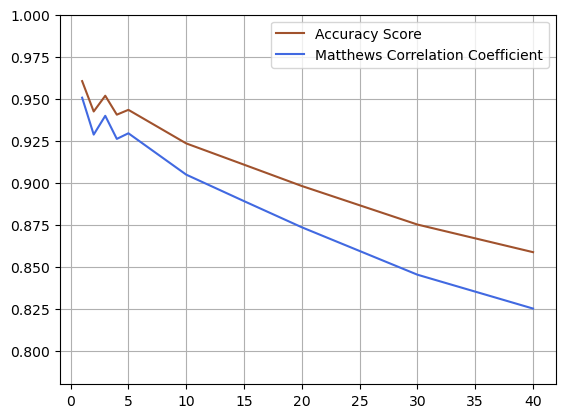

In [106]:
# Define a set of K neighbours
ks = np.array([1, 2, 3, 4, 5, 10, 15, 20, 30, 40])
accs = np.zeros(ks.shape[0])
mccs = np.zeros(ks.shape[0])

# Loop through differente k's and calculate Accuracy Score
for i,k in enumerate(ks):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train_processed, y_train)
    preds_knn = model_knn.predict(X_test_processed)
    accs[i] = accuracy_score(y_test, preds_knn)
    mccs[i] = matthews_corrcoef(y_test, preds_knn)

# Plot results
plt.plot(ks, accs, color = "sienna", label = "Accuracy Score")
plt.plot(ks, mccs, color = "royalblue", label = "Matthews Correlation Coefficient")
plt.grid()
plt.legend(loc = "upper right")
plt.ylim(0.78,1)
plt.show()

#### 5.5 Select best model and fit the model with all the Training Set Data

List the classification models according to MCC

In [107]:
Best_Models = pd.concat([Best_lr[:4], Best_lda[:3], Best_qda[:1], Best_dt[:4], Best_nb[:1], Best_knn[:4]])
Best_Models = Best_Models.sort_values(by="MCC", ascending=False)
Best_Models[:10]

,Model Name,Accuracy,MCC
0,KNN (k=1),0.960459,0.950596
3,"Decision Tree (msl=1, max_depth=25)",0.958410,0.947983
2,"Decision Tree (msl=1, max_depth=20)",0.958052,0.947538
6,"Decision Tree (msl=5, max_depth=20)",0.952059,0.940037
2,KNN (k=3),0.951752,0.939803
7,"Decision Tree (msl=5, max_depth=25)",0.951393,0.939206
4,KNN (k=5),0.943352,0.929408
1,KNN (k=2),0.942379,0.928622
4,Logistic Regression (L2) (C=1),0.776122,0.720117
3,Logistic Regression (L2) (C=0.1),0.769617,0.712102


In [116]:
k = 1
# Fit best model with all the Training Set Data
Best_Model = KNeighborsClassifier(n_neighbors = k)
Best_Model = Best_Model.fit(X_train_processed, y_train)

In [119]:
df_preds = Best_Model.predict(X_test_processed)
print("These are the statistics for the selected Classification Model:")
print("The Accuracy score is: %7.4f" % accuracy_score(y_test, df_preds))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, df_preds))
print("This is the Confusion Matrix")
pd.DataFrame(confusion_matrix(y_test, df_preds))

These are the statistics for the selected Classification Model:
The Accuracy score is:  0.9605
The Matthews correlation coefficient is:  0.9506
This is the Confusion Matrix


,0,1,2,3,4
0,4052,9,2,0,0
1,10,3529,18,90,106
2,35,1,4093,53,3
3,22,8,147,3477,3
4,9,188,29,39,3601
